This Project overall explores the various news articles and analyze it with the use of some famous NLP methods like LDA, NMF and PCA plots of the results. This project also explores some scores that is attached with each unique news articles.

In [1]:
!pip install textstat

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import textstat
import re


nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


As I was getting error to resolve it I needed to download all in nltk.

In [3]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

Now below code explores the news articles body text part and then provides numerical insights. News articles were taken from online resources however some articles were forbidden to access or the body text part was not mtching the requirement thus we have removed them from the dataset. Here most of the news articles are from health, sport and politics however some other miscellaneous also exist in dataset.

In [4]:
!pip install readability-lxml

In [5]:
from readability import Document
def scrape_article_text(url):
    """
    Download and parse the main article body using readability-lxml.
    """
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        # Use Readability to extract the “main” HTML
        doc = Document(resp.text)
        content_html = doc.summary()
        # Convert that HTML into plain text
        soup = BeautifulSoup(content_html, 'html.parser')
        paragraphs = soup.find_all('p')
        # Join non-empty paragraphs with newline (or space)
        texts = [p.get_text().strip() for p in paragraphs if p.get_text().strip()]
        return "\n".join(texts)
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return ""


def text_analysis(article_text):
    """
    Perform text analysis and calculate various readability, sentiment,
    and lexical diversity metrics.
    """
    if not article_text:
        return {}

    sentences = sent_tokenize(article_text)
    words     = word_tokenize(article_text)

    filtered = [w for w in words
                if w.isalpha() and w.lower() not in stop_words]

    total_words = len(filtered)
    total_sents = len(sentences) or 1
    avg_wps     = total_words / total_sents

    blob         = TextBlob(article_text)
    polarity     = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    complex_words = [w for w in filtered
                     if textstat.syllable_count(w) >= 3]
    complex_count = len(complex_words)
    avg_complex_per_sent = complex_count / total_sents

    # Readability metrics
    fog_idx      = textstat.gunning_fog(article_text)
    flesch_ease  = textstat.flesch_reading_ease(article_text)
    fk_grade     = textstat.flesch_kincaid_grade(article_text)
    smog         = textstat.smog_index(article_text)
    coleman_liau = textstat.coleman_liau_index(article_text)
    ari          = textstat.automated_readability_index(article_text)
    dale_chall   = textstat.dale_chall_readability_score(article_text)
    linsear      = textstat.linsear_write_formula(article_text)
    lix_score    = textstat.lix(article_text)
    text_std     = textstat.text_standard(article_text, float_output=True)
    reading_time = textstat.reading_time(article_text)

    avg_syllables = (sum(textstat.syllable_count(w) for w in filtered)
                     / total_words) if total_words else 0
    avg_word_len  = (sum(len(w) for w in filtered)
                     / total_words) if total_words else 0
    lexical_div   = (len(set(filtered)) / total_words) if total_words else 0

    return {
        'total_words': total_words,
        'avg_words_per_sentence':     avg_wps,
        'polarity':                   polarity,
        'subjectivity':               subjectivity,
        'fog_index':                  fog_idx,
        'complex_word_count':         complex_count,
        'avg_complex_per_sentence':   avg_complex_per_sent,

        'flesch_reading_ease':        flesch_ease,
        'flesch_kincaid_grade':       fk_grade,
        'smog_index':                 smog,
        'coleman_liau_index':         coleman_liau,
        'automated_readability_index':ari,
        'dale_chall_score':           dale_chall,
        'linsear_write_formula':      linsear,
        'lix':                        lix_score,
        'text_standard_grade':        text_std,
        'reading_time_minutes':       reading_time,

        'avg_syllables_per_word':     avg_syllables,
        'avg_word_length_chars':      avg_word_len,
        'lexical_diversity':          lexical_div,
    }

def process_articles(csv_file, output_file='article_analysis_results_newspaper.csv'):
    """
    Reads a CSV with a 'url' column, scrapes each URL via newspaper3k,
    analyzes the text, and writes a combined CSV.
    """
    df = pd.read_csv(csv_file)
    # Scrape texts
    df['article_text'] = df['url'].apply(scrape_article_text)
    # Analyze each article
    analysis = df['article_text'].apply(text_analysis).tolist()
    analysis_df = pd.DataFrame(analysis)
    # Combine and save
    result = pd.concat([df, analysis_df], axis=1)
    result.to_csv(output_file, index=False)
    print(f"Done! Results saved to {output_file}")

# Example usage:
process_articles('/content/news_articles1.csv')

Error scraping https://www.ft.com/content/219fb93b-7ee8-4eb5-b0a2-2b2e386b1d41: 403 Client Error: Forbidden for url: https://subs.ft.com/fallback?ft-content-uuid=219fb93b-7ee8-4eb5-b0a2-2b2e386b1d41
Error scraping https://www.ft.com/content/506f5a03-8520-40e1-aee3-a6e6427f68c0: 403 Client Error: Forbidden for url: https://subs.ft.com/fallback?ft-content-uuid=506f5a03-8520-40e1-aee3-a6e6427f68c0
Done! Results saved to article_analysis_results_newspaper.csv


Most of the above scores are for overall understanding of text like complexity, readability etc. Many scores like flesch_reading_ease, flesch_kincaid_grade, coleman_liau_index are for readability and we found this are somewhat popular in US schools and general usage. Most of this data obviously will not represent much thing however it could be helpful if the news article follows the less complex and readble format than it can attract more users. We are not doing any analysis of user engagement here.

# EDA

Now we are moving to the EDA part. Previously in the mid term report we mentioned some word clouds, bag of words and scores that we got from previous code function. However, it was not enough to represnt the understanding of our work. Also the biasness or skewness was not presented in form of visualization or correlation. Here we are doing it again to show good understanding.

In [6]:
df1 = pd.read_csv('/content/article_analysis_results_newspaper.csv')

In [7]:
df1.sample(5)

,id,url,article_text,total_words,avg_words_per_sentence,polarity,subjectivity,fog_index,complex_word_count,avg_complex_per_sentence,...,coleman_liau_index,automated_readability_index,dale_chall_score,linsear_write_formula,lix,text_standard_grade,reading_time_minutes,avg_syllables_per_word,avg_word_length_chars,lexical_diversity
105,120,https://www.npr.org/sections/global-health/,"Hnoi Lathitham, 57, holds a bowl of Gang Liang...",30.0,10.000000,0.050000,0.300000,12.29,7.0,2.333333,...,10.73,11.1,11.91,10.833333,46.41,12.0,3.82,2.000000,6.266667,0.933333
93,105,https://ipnews.com.br/ciberseguranca-e-destaqu...,O que você vai ver nesse artigo:\nOs choques e...,387.0,24.187500,0.006818,0.215909,17.46,89.0,5.562500,...,14.22,17.9,13.41,13.200000,62.16,17.0,36.83,1.878553,5.863049,0.625323
40,42,https://talksport.com/darts/3164323/andy-jenki...,Former World Championship semi-finalist Andy J...,222.0,12.333333,0.135833,0.516944,13.43,49.0,2.722222,...,11.09,14.3,10.01,13.000000,51.20,13.0,32.32,1.909910,6.247748,0.770270
39,41,https://www.news.com.au/sport/olympics/athleti...,After the success of this year’s Stawell Gift ...,229.0,13.470588,0.133385,0.348887,12.97,43.0,2.529412,...,9.06,12.8,9.02,14.750000,45.63,13.0,28.57,1.755459,5.781659,0.755459
86,93,https://en.wikipedia.org/wiki/Public_health_em...,Formal declaration by the World Health Organiz...,1471.0,12.903509,0.075986,0.310334,13.60,504.0,4.421053,...,12.02,16.1,8.37,40.000000,55.43,14.0,224.40,2.284160,6.804215,0.486744


In [8]:
print(df1.describe())

print(df1.isna().sum())

               id  total_words  avg_words_per_sentence   polarity  \
count  107.000000    99.000000               99.000000  99.000000   
mean    57.616822   561.919192               20.361409   0.111218   
std     35.077716   852.099085               44.942232   0.095710   
min      1.000000     1.000000                1.000000  -0.118493   
25%     27.500000   100.500000               11.315789   0.056028   
50%     55.000000   309.000000               13.428571   0.109111   
75%     86.500000   645.000000               16.010490   0.163479   
max    121.000000  6339.000000              423.000000   0.500000   

       subjectivity   fog_index  complex_word_count  avg_complex_per_sentence  \
count     99.000000   99.000000           99.000000                 99.000000   
mean       0.383411   17.122626          155.676768                  5.847281   
std        0.164101   25.369716          251.824438                 11.968928   
min        0.000000    1.200000            0.000000   

In [9]:
df1.shape

(107, 23)

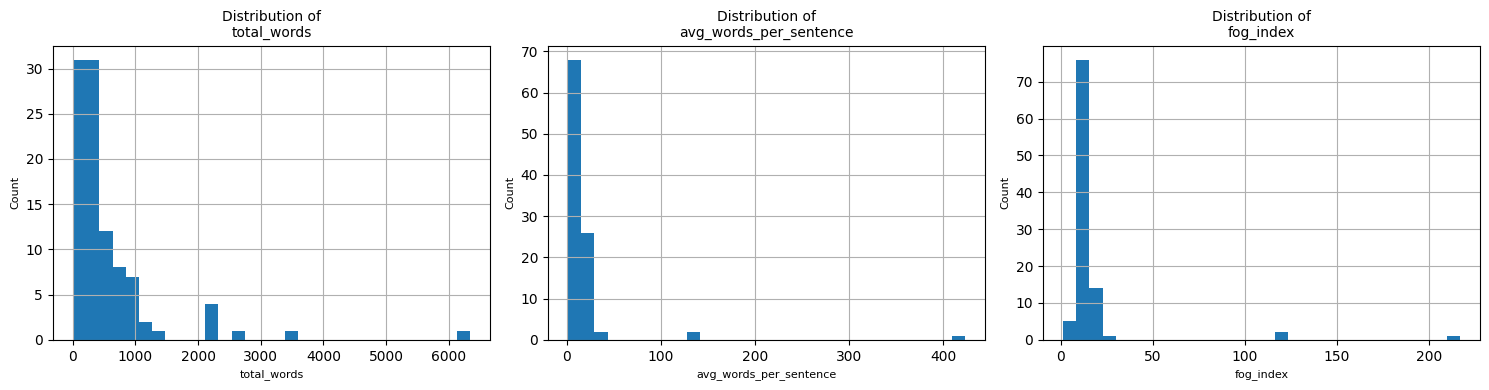

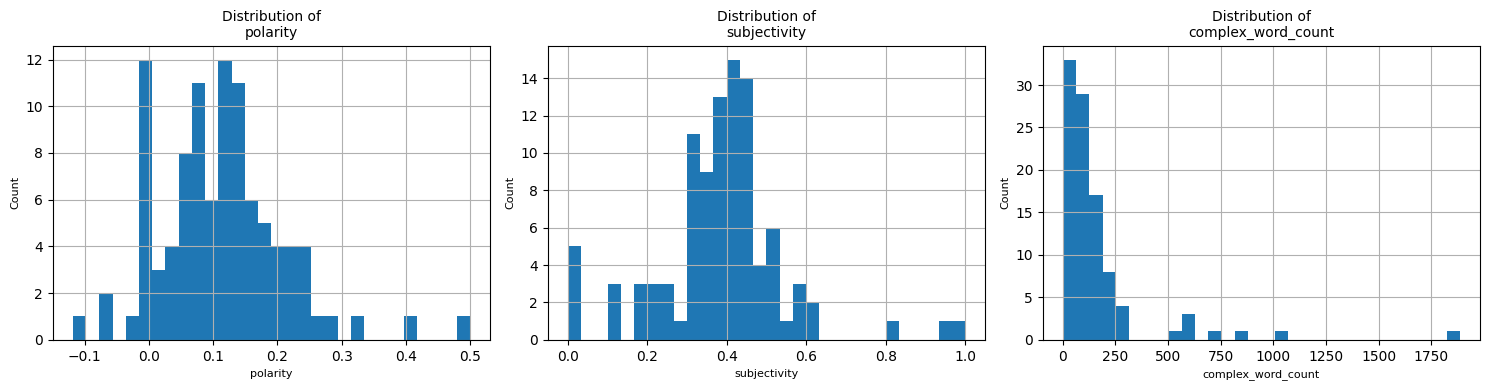

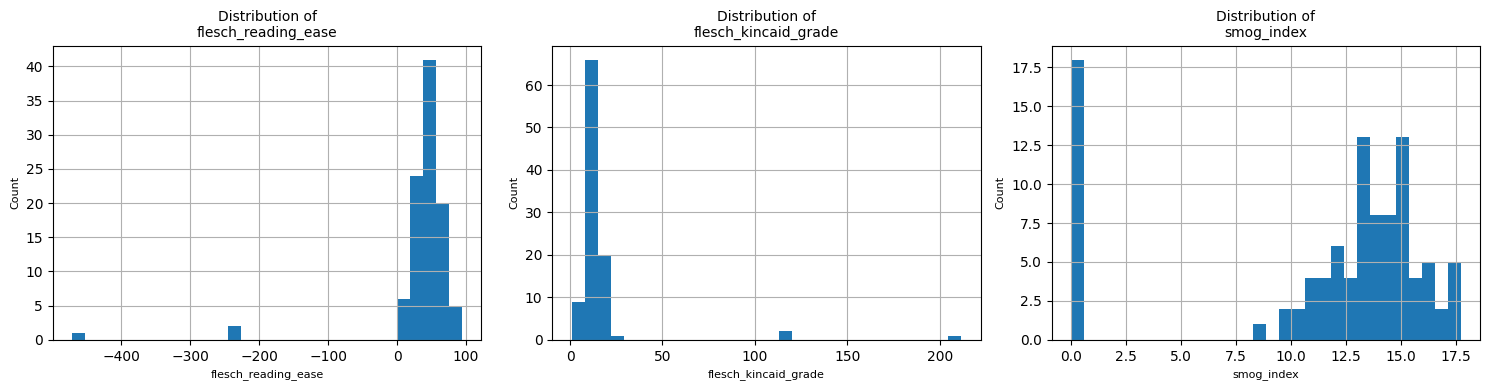

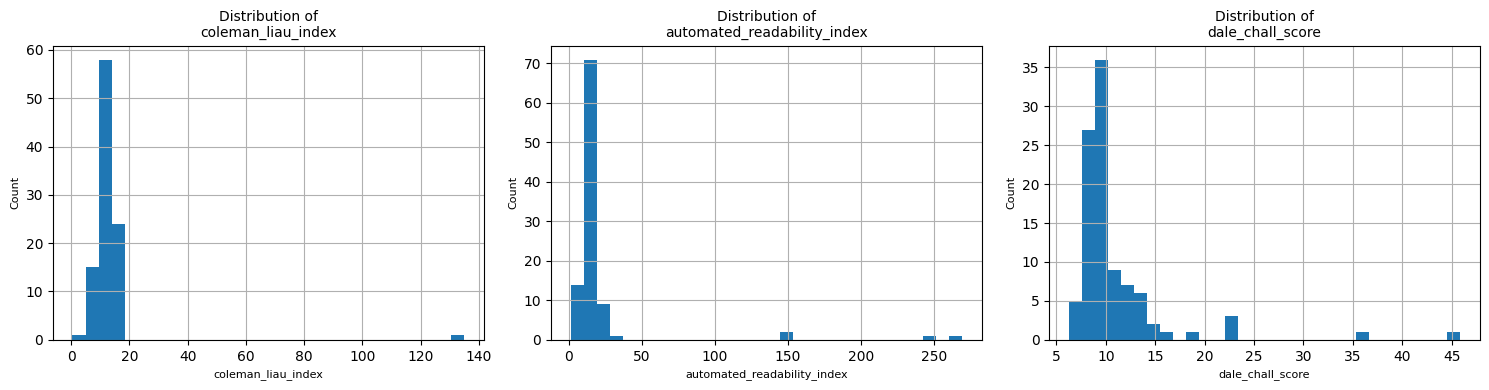

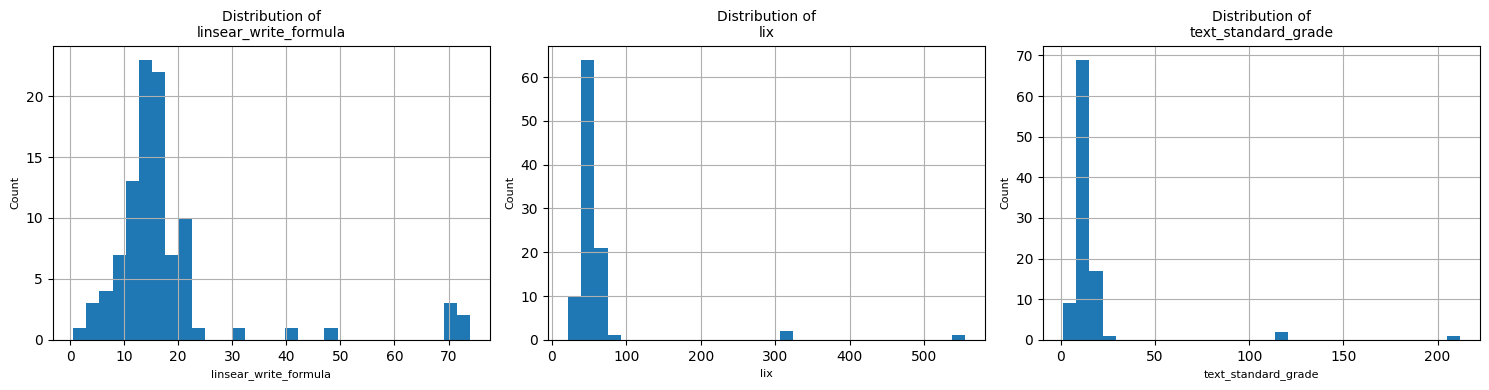

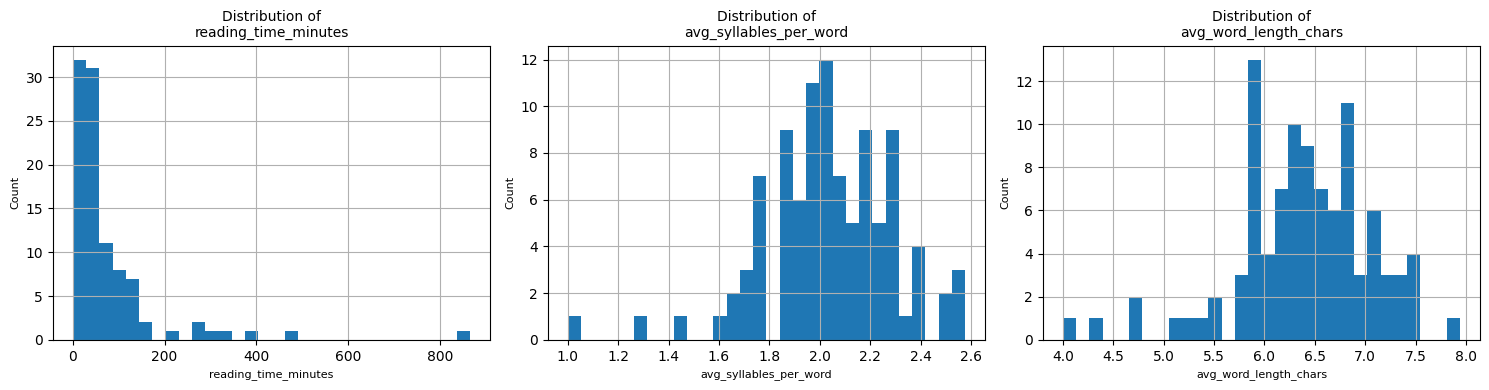

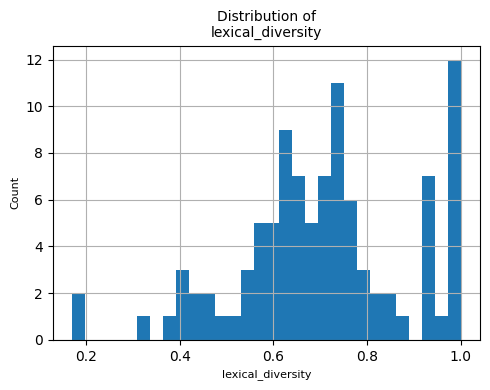

In [10]:
import matplotlib.pyplot as plt
import math

metrics = [
    'total_words',
    'avg_words_per_sentence',
    'fog_index',
    'polarity',
    'subjectivity',
    'complex_word_count',
    'flesch_reading_ease',
    'flesch_kincaid_grade',
    'smog_index',
    'coleman_liau_index',
    'automated_readability_index',
    'dale_chall_score',
    'linsear_write_formula',
    'lix',
    'text_standard_grade',
    'reading_time_minutes',
    'avg_syllables_per_word',
    'avg_word_length_chars',
    'lexical_diversity'
]

per_row = 3

for i in range(0, len(metrics), per_row):
    chunk = metrics[i:i+per_row]
    n = len(chunk)

    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)

    for ax, m in zip(axes[0], chunk):
        df1[m].hist(bins=30, ax=ax)
        ax.set_title(f'Distribution of\n{m}', fontsize=10)
        ax.set_xlabel(m, fontsize=8)
        ax.set_ylabel('Count', fontsize=8)

    plt.tight_layout()
    plt.show()


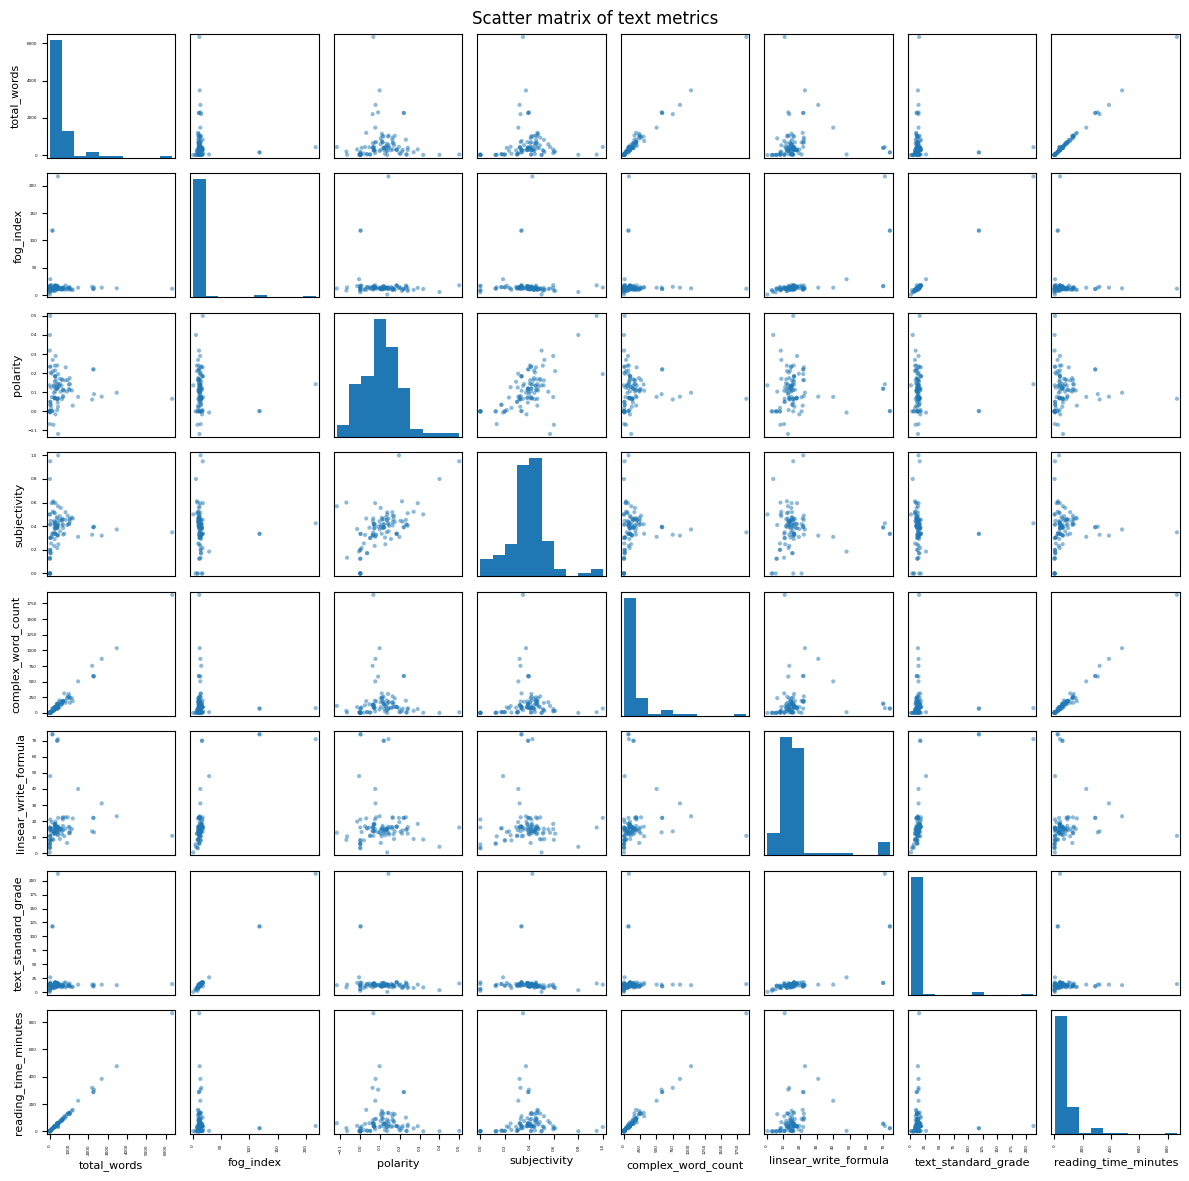

In [11]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
metrics = [
    'total_words',
    'fog_index',
    'polarity',
    'subjectivity',
    'complex_word_count',
    'linsear_write_formula',
    'text_standard_grade',
    'reading_time_minutes',
]

axes = scatter_matrix(
    df1[metrics],
    figsize=(12, 12),
    diagonal='hist'
)

for ax in axes.ravel():
    ax.xaxis.label.set_size(8)
    ax.yaxis.label.set_size(8)
    ax.tick_params(axis='both', labelsize=3)

plt.suptitle("Scatter matrix of text metrics", fontsize=12)
plt.tight_layout()
plt.show()


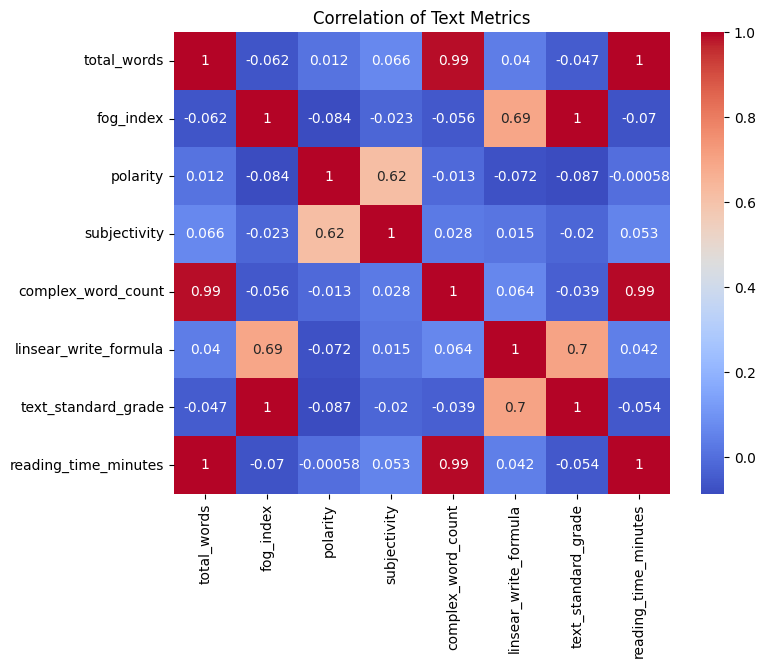

In [12]:
corr = df1[metrics].corr()
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation of Text Metrics")
plt.show()


Now we will do some text addition in the csv file to make insights. We are extracting the text from website and saving it into new column called article_text.

In [13]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words and len(t)>2]
    return " ".join(tokens)
df1 = df1.dropna(subset=['article_text'])

df1['article_text'] = df1['article_text'].fillna('')

df1['clean'] = df1['article_text'].apply(clean_text)

<ipython-input-13-35a12a2eaab5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['article_text'] = df1['article_text'].fillna('')


There are many ways to do some analysis and LDA is one of the most popular and old method to follow. We can learn more about this in [This YouTube video](https://youtu.be/T05t-SqKArY?si=m0I0QJYJyAdMZnOP) which is in 2 parts and also from [LDA Paper](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf).

# LDA

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(
    stop_words='english',
    max_df=0.5,
    min_df=0.05,
    ngram_range=(1, 3)
)
dtm = vect.fit_transform(df1['clean'])


Here n-gram is concept where combination of n words are combined to show frequency or pattern.

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=6,
    max_iter=50,
    learning_method='online',
    learning_decay=0.7,
    learning_offset=50.0,
    doc_topic_prior=0.1,
    topic_word_prior=0.01,
    random_state=0
)
lda.fit(dtm)


LatentDirichletAllocation(doc_topic_prior=0.1, learning_method='online',
                          learning_offset=50.0, max_iter=50, n_components=6,
                          random_state=0, topic_word_prior=0.01)

In [16]:
words = vect.get_feature_names_out()
for i, comp in enumerate(lda.components_):
    top_idxs = comp.argsort()[-10:][::-1]
    print(f"Topic {i}: " + ", ".join(words[j] for j in top_idxs))


Topic 0: games, olympic, cup, photo, file, shows, taken, photo taken, file photo, file photo taken
Topic 1: content, music, black, article, want, time, country, continue, provided, view
Topic 2: health, world cup, fifa, cup, english, time, global, countries, group, qatar
Topic 3: sports, said, year, says, time, like, years, award, bbc, sport
Topic 4: cup, world cup, fifa, tournament, match, qatar, final, teams, group, time
Topic 5: health, global, countries, said, research, time, cases, international, global health, disease


Here we can see that this topics are clearly distinguishing the theme. We can also do changes in parameter to tweak but here the results are satisfactory.

We can do visualization using pyLDAvis like below.

In [17]:
!pip install pyLDAvis

In [18]:
# %pip install --upgrade pyldavis numpy

import numpy as np
import pyLDAvis
import pyLDAvis.lda_model as lda_vis
from joblib import parallel_backend

pyLDAvis.enable_notebook()

with parallel_backend('threading'):
    vis = lda_vis.prepare(lda, dtm, vect)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.176513 -0.112852       1        1  33.185471
4     -0.107295 -0.095694       2        1  25.912875
0     -0.274146  0.031523       3        1  23.742449
3      0.058985  0.053509       4        1  16.034396
1      0.109594  0.145380       5        1   1.094322
2      0.036349 -0.021864       6        1   0.030487, topic_info=           Term        Freq       Total Category  logprob  loglift
572      health  292.000000  292.000000  Default  30.0000  30.0000
1487  world cup  331.000000  331.000000  Default  29.0000  29.0000
303         cup  373.000000  373.000000  Default  28.0000  28.0000
470        fifa  228.000000  228.000000  Default  27.0000  27.0000
530      global  193.000000  193.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
750         los    0.009049   44.535276   Topic6  -6.9655  -0.4058
500    football    0.009430  102.295489   Topic6  -6.9243  -1.1961
1403     united    0.009330  110.164258   Topic6  -6.9350  -1.2809
1275     states    0.009229  100.685893   Topic6  -6.9458  -1.2017
1145       said    0.009181  183.877184   Topic6  -6.9510  -1.8093

[412 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4         1  0.990087      access
5         1  0.953825  accessible
22        1  0.864193     address
22        2  0.072016     address
27        1  0.949657      adults
...     ...       ...         ...
1508      1  0.113554       youre
1508      4  0.908432       youre
1510      1  0.074428     zealand
1510      2  0.699623     zealand
1510      3  0.223284     zealand

[843 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 4, 2, 3])

Its really amazing how we can viusalize each result with topics. Here we can select topic hover on them to see word frequency and many more options and buttons.

Now we will do non-negative matrix factorization which can be learn from [This](https://www.geeksforgeeks.org/non-negative-matrix-factorization/) link.

#NMF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_df=0.3,
    min_df=0.02,
    ngram_range=(1,2),
    sublinear_tf=True
)
tfidf_dtm = tfidf.fit_transform(df1['clean'].fillna(""))


In [20]:
from sklearn.decomposition import NMF

nmf = NMF(
    n_components=6,
    init='random',
    solver='mu',
    beta_loss='kullback-leibler',
    random_state=42,
    max_iter=500
)
W = nmf.fit_transform(tfidf_dtm)
H = nmf.components_


In [21]:

nmf = NMF(
    n_components=6,
    init='random',
    solver='mu',
    beta_loss='kullback-leibler',
    random_state=42,
    max_iter=500,
    alpha_W=0.01,
    alpha_H=0.01,
    l1_ratio=0.1
)


In [22]:
feature_names = tfidf.get_feature_names_out()
for i, topic in enumerate(H):
    top_idxs = topic.argsort()[-10:][::-1]
    terms    = [feature_names[j] for j in top_idxs]
    print(f"Topic {i}: " + ", ".join(terms))


Topic 0: tell, add, ist, spread, content, oct, van, free, updated, disease
Topic 1: global health, access, asthma, wellness, care, research, health research, weekly, leaders, inhaled
Topic 2: says, que, experience, sports, live, sky sports, sky, bbc, way, para
Topic 3: sports, live, football, independent source, policy research, polling, source health, polling news, research polling, health policy
Topic 4: taylor, ist, mark, adam, sarah, china, hope, disability, report, access
Topic 5: zhao, zhao xintong, xintong, sports, lions, latest, game, adam, williams, end


We can see that here just like lda it is showing good cluster of diffrent topic wise text words.

# spaCy

In [23]:
import spacy
import pandas as pd
from collections import Counter
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

entity_counter = Counter()

for doc in nlp.pipe(df1['article_text'].fillna(""), batch_size=20, disable=["tagger","parser","lemmatizer"]):
    for ent in doc.ents:
        entity_counter[(ent.label_, ent.text.strip())] += 1

ent_rows = [
    {"label": label, "entity": text, "count": cnt}
    for (label, text), cnt in entity_counter.items()
]
ents_df = pd.DataFrame(ent_rows)

top_entities = (
    ents_df
    .sort_values(["label","count"], ascending=[True, False])
    .groupby("label")
    .head(10)
    .reset_index(drop=True)
)

top_entities.to_csv("top_named_entities.csv", index=False)
print(top_entities)


           label                                             entity  count
0       CARDINAL                                                two    117
1       CARDINAL                                              three     91
2       CARDINAL                                                one     67
3       CARDINAL                                               four     51
4       CARDINAL                                              eight     48
..           ...                                                ...    ...
168  WORK_OF_ART  The Road to Becoming a Sports Powerhouse - The...      2
169  WORK_OF_ART                                    La Marseillaise      2
170  WORK_OF_ART                                     Like a Lioness      2
171  WORK_OF_ART                               Woman, Life, Freedom      2
172  WORK_OF_ART                                      Global Report      2

[173 rows x 3 columns]


This result basically shows just some of the basic word mentioned and their label or category they belongs mentioned with their frequency.

# Viz

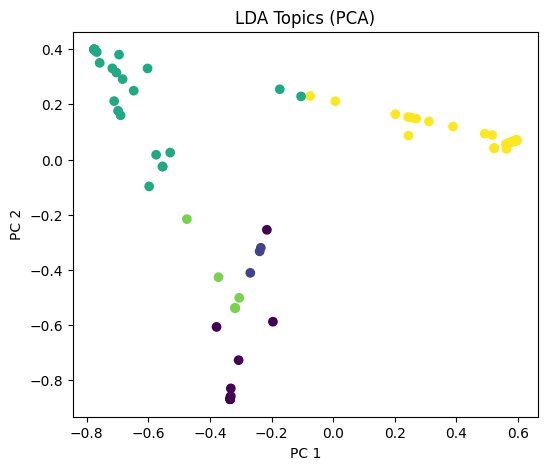

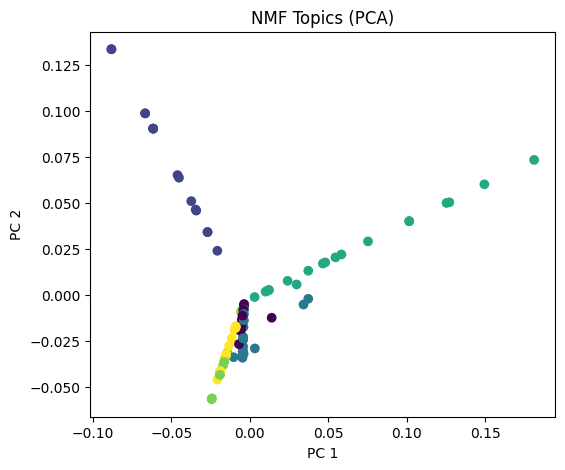

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

lda_doc_topic = lda.transform(dtm)
dominant_lda   = lda_doc_topic.argmax(axis=1)

coords = PCA(n_components=2).fit_transform(lda_doc_topic)
plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1], c=dominant_lda)
plt.title("LDA Topics (PCA)")
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.show()

nmf_doc_topic = nmf.fit_transform(tfidf_dtm)
dominant_nmf   = nmf_doc_topic.argmax(axis=1)

coords = PCA(n_components=2).fit_transform(nmf_doc_topic)
plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1], c=dominant_nmf)
plt.title("NMF Topics (PCA)")
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.show()

When we run LDA or NMF, each document gets represented as a vector of length K (where K is our number of topics) for example, [0.01, 0.05, 0.02, …, 0.80] for an 8-topic model. That's great for downstream clustering or scoring, but it lives in an 8-dimensional space, which we can't directly plot. Thus we can ue PCA for two dimensional plot with 2 principal component. PCA uses the concept of eigenvectors and eigenvalues.

## Doc2Vec

Doc2Vec embeddings capture semantic and stylistic patterns.

In [25]:
!pip install --upgrade --force-reinstall numpy gensim

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp

In [25]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
import pandas as pd

In [26]:
documents = [
    TaggedDocument(words=doc.split(), tags=[i])
    for i, doc in enumerate(df1['clean'].fillna(""))
]

d2v = Doc2Vec(
    documents,
    vector_size=100,
    window=5,
    min_count=2,
    epochs=40,
    workers=4,
    seed=0
)


In [27]:
embeddings = [d2v.dv[i] for i in range(len(documents))]

In [28]:
n_clusters = 8
km = KMeans(n_clusters=n_clusters, random_state=0)
labels = km.fit_predict(embeddings)

df1['doc2vec_cluster'] = labels

In [29]:
df1['doc2vec_cluster'].value_counts()

,count
doc2vec_cluster,
3,36
1,32
7,25
2,2
4,1
0,1
6,1
5,1


In [32]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## SBERT & KMeans

In [30]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [31]:
sbert = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert.encode(
  df1['clean'].fillna("").tolist(),
  show_progress_bar=True,
  convert_to_numpy=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
n_clusters = 8
km = KMeans(n_clusters=n_clusters, random_state=0)
labels = km.fit_predict(embeddings)

df1['sbert_cluster'] = labels

In [33]:
df1.groupby('sbert_cluster')['url'].count().sort_values(ascending=False)

,url
sbert_cluster,
4,29
6,18
7,16
2,11
0,10
1,7
3,4
5,4


Using SBERT plus KMeans gives you a way to group your articles by semantic similarity rather than just bag of words overlap.

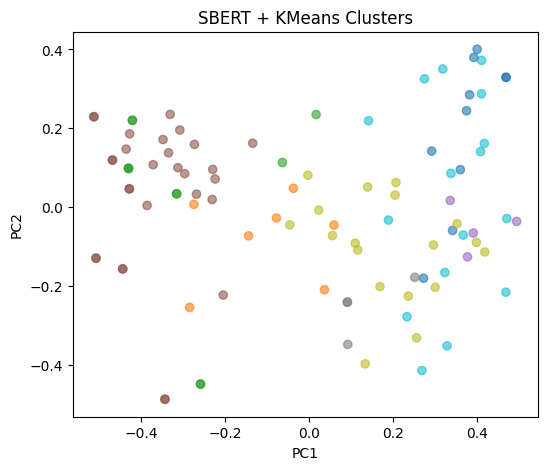

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_2d(embeds, labels, title):
    coords = PCA(n_components=2).fit_transform(embeds)
    plt.figure(figsize=(6,5))
    plt.scatter(coords[:,0], coords[:,1], c=labels, cmap='tab10', alpha=0.6)
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

plot_2d(embeddings, df1['sbert_cluster'], "SBERT + KMeans Clusters")

## Conclusion

In conclusion we can say we developed an end-to-end pipeline for scraping and analyzing news articles. First, we computed readability and sentiment metrics (e.g. average sentence length, Gunning-Fog index, polarity) to characterize writing style. Next, we applied topic modeling (LDA, NMF) and semantic clustering (SBERT + K-Means) to uncover the main themes and group similar stories. We also extracted named entities to highlight the most frequently mentioned people, organizations, and places.

These experiments demonstrated that our approach can automatically surface both quantitative text features and latent topics across a large corpus. However, our scraping heuristics and choice of hyperparameters (number of topics, embedding model) impose some limitations on generality.